# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
import pywt #gaussian
from spicy import signal
from scipy.signal import butter, sosfilt, cwt, morlet, ricker
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})


In [19]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']

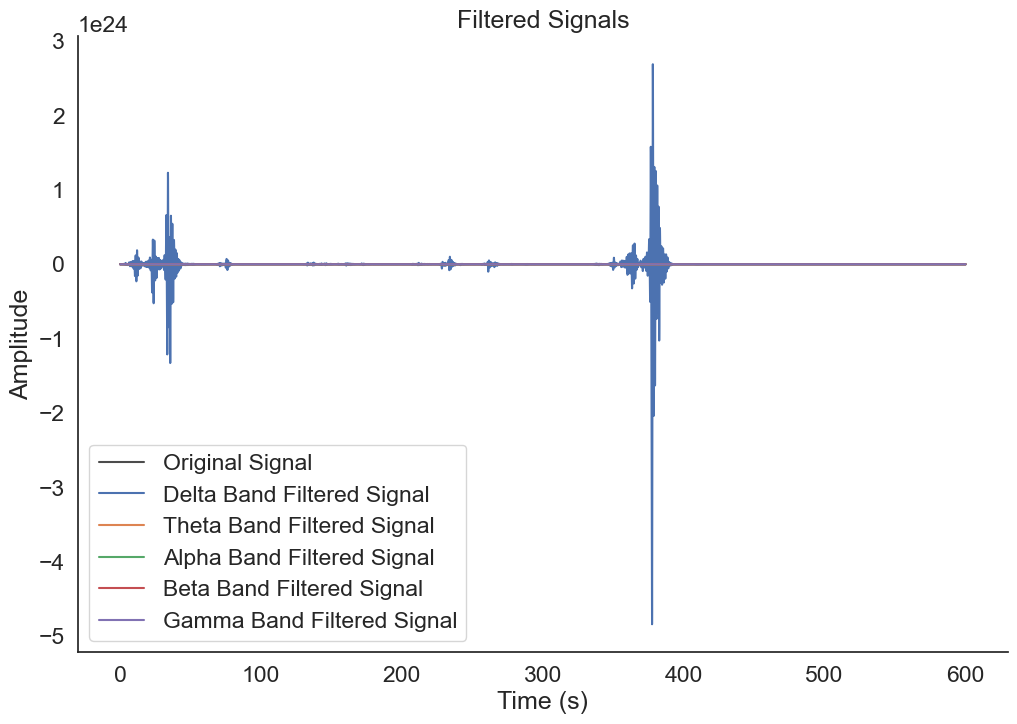

In [21]:
frequency_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 100)
}

# This is to filter the different frequency bands
filtered_signals = {}
for band, (low, high) in frequency_bands.items():
    a, b = signal.butter(4, [low / (sampling_rate / 2), high / (sampling_rate / 2)], btype='band')
    filtered_signals[band] = signal.filtfilt(a, b, lfp)


time = np.arange(len(lfp)) / sampling_rate
plt.figure(figsize=(12, 8))
plt.plot(time, lfp, label='Original Signal', color='black', alpha=0.7)
for band, filtered_signal in filtered_signals.items():
    plt.plot(time, filtered_signal, label=f'{band.capitalize()} Band Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Signals')
plt.legend()
plt.show()

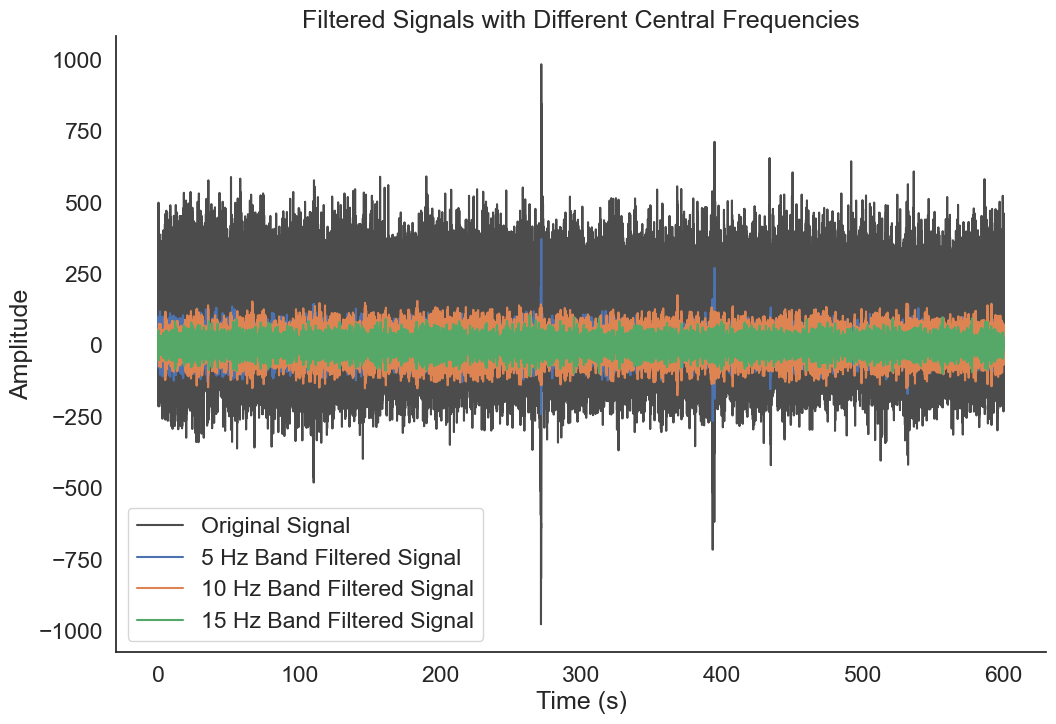

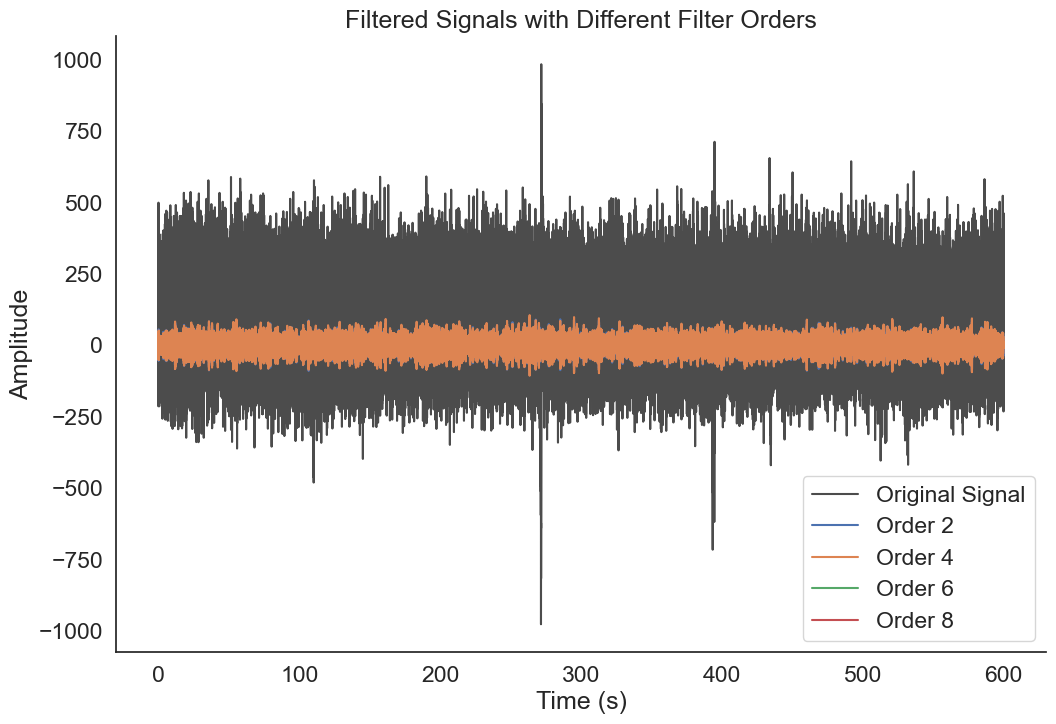

402 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
464 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
514 µs ± 8.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
574 µs ± 6.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
central_freq = 10  
bandwidth = 5  

# Filter the signal with different frequencies
filtered_signals = {}
for cf in [5, 10, 15]:  # Central frequencies to try
    low = cf - bandwidth / 2
    high = cf + bandwidth / 2
    b, a = signal.butter(4, [low / (sampling_rate / 2), high / (sampling_rate / 2)], btype='band')
    filtered_signals[f'{cf} Hz'] = signal.filtfilt(b, a, lfp)

# Plot 
plt.figure(figsize=(12, 8))
plt.plot(time, lfp, label='Original Signal', color='black', alpha=0.7)
for label, filtered_signal in filtered_signals.items():
    plt.plot(time, filtered_signal, label=f'{label} Band Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Signals with Different Frequencies')
plt.legend()
plt.show()


filter_orders = [2, 4, 6, 8]

# Filter the signal with different orders
filtered_signals = {}
for order in filter_orders:
    b, a = signal.butter(order, [low / (sampling_rate / 2), high / (sampling_rate / 2)], btype='band')
    filtered_signals[f'Order {order}'] = signal.filtfilt(b, a, lfp)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(time, lfp, label='Original Signal', color='black', alpha=0.7)
for label, filtered_signal in filtered_signals.items():
    plt.plot(time, filtered_signal, label=label)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Signals with Different Orders')
plt.legend()
plt.show()

# Compare computing time
for order in filter_orders:
    %timeit signal.butter(order, [low / (sampling_rate / 2), high / (sampling_rate / 2)], btype='band')


- Considering the filtered signal, we can see that as the central frequency of the filter increases (from 5Hz to 15 Hz) the amplitude of the filtered signal decreases. Keeping the central frequency fixed but changing the bandwith affects the amplitude and shape of the filtered signal. Narrower bandwidths result in stronger attenuation of frequencies outside the band, leading to a more pronounced filtering effect.
- Considering the computing time, we can see that as the filter order increase (from 2 to 8), the computational time required for the filtering also increases. High-order filters use more complex calculations. On the other hand, the execution time increases from approximately 402 µs for an order of 2 to 574 µs for an order of 8. This demonstrates the increasing computational complexity associated with higher-order filters.

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.